### **Traffic Sign Detection - Project**

- **Author**: Uyen Nguyen
- **Date**: 2023/09/29
- **Course**: AI Vietnam - Course 2023
- **Module**: Machine Learning

#### **I. Introduction**

***Traffic Sign Dectection*** is a problem applied algorithms related to the field of Object Detection to detect traffic signs on road. Normally, a Traffic Sign Detection program includes two parts, which includes locating the signs and recognizing the traffic sign. So, a high-accuracy program needs to well-build the two parts mentioned above.

In this project, we will build a Traffic Sign Detection using Support Vector Machine (SVM). Defining the inpput and output of the program as follows:
- **Input**: A picture of a traffic sign
- **Output**: The location and class of the sign in the picture

#### **II. Program Installation**

In this part, we will start to build the program to detect different types of traffic signs. For the sake of the easeness of forming and logical thinking of building this program, this section will be split into two sections, corresponding to two main modules. These include "*Building a classification model using SVM*" and "*Building an Object Detect model using sliding window technique*".

##### **1. Traffic Sign Classification Model Using SVM**

##### **a. Import necessary libraries**

In [55]:
# Import necessary library
import time
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

##### **b. Data Loading**

We begin to read and store picture files and associated labels into 2 different lists, corresponding to X and y in our traffic signs classification problem. Inside the data folder, we have two other folders:
- **images**: Folder with pictures
- **annotations**: Folder with .xml file, which is the label file, contains the information about coordinate and class of objects in the coressponding pictures

First, we will declare the (relative) path to the two folders as well as two empty lists to store the pictures and labels as we're going through:

In [56]:
# Declare the path to the two images and annotations folder
annotations_dir = "../data/traffic_sign_detection/annotations"
img_dir         = "../data/traffic_sign_detection/images"

# Create two emmpty lists to store images and labels 
label_lst = []
img_lst  = []

The following code chunk contains of a few different steps to expand the `img_lst` and `label_lst` above:


1. First, we will browse through each .xml file in **annotations** folder. To browser every file name in a folder, we will use `os.listdir()` function. To create a complete path to the .xml file, we use `os.path.join(path1, path2)` to connect folder annotations and file name together. 

2. Examining a sample .xml file in the annotations folder, we can see the following information:

    ```
    <annotation>
        <folder>images</folder>
        <filename>road0.png</filename>
        <size>
            <width>267</width>
            <height>400</height>
            <depth>3</depth>
        </size>
        <segmented>0</segmented>
        <object>
            <name>trafficlight</name>
            <pose>Unspecified</pose>
            <truncated>0</truncated>
            <occluded>0</occluded>
            <difficult>0</difficult>
            <bndbox>
                <xmin>98</xmin>
                <ymin>62</ymin>
                <xmax>208</xmax>
                <ymax>232</ymax>
            </bndbox>
        </object>
    </annotation>
    ```
    Inside a .xml file, we will get multiple information about the picture, and the most important information that we want to focus on this project is coordination information and class name of the object (in this case is the traffic sign). So that, we will care about <**name**> and <**bndbox**> entities. Inside a <*object*> entity, <*name*> corresponds to its class and <*bnd*> gives information about its location (coordinate) in the picture. To read the content of a .xml file in Python, we can use this xml module as demonstrated in the code

3. The xml module also allow us to interact with different entities in a .xml file. After getting the root, we can search for/extract information of child entities of the root. For example, we can get the information of the <*folder*> entity to read the name of the image file.

4. Similarly, we can get information about <*name*> of <*object*>. Because a single picture can contain different objects, we will use a loop to browse each object if needed.

5. Finally, we will get information about the coordinates of the <*bndbox*> and extract the object picture to store in the `img_lst`. We also save the `classname` in the `label_lst`

In [57]:
for xml_file in os.listdir(annotations_dir):
    # Step 1: Connect folder annotations and file name together
    xml_filepath = os.path.join(annotations_dir, xml_file)

    # Step 2: Implement the xml module to read the content of the .xml file
    tree = ET.parse(xml_filepath)
    root = tree.getroot()

    # Step 3: Use xml module to get the image file name and create a path to the corresponding image file
    folder = root.find("folder").text
    img_filename = root.find("filename").text
    img_filepath = os.path.join(img_dir, img_filename)
    img = cv2.imread(img_filepath)

    # Step 4: Get information about the name of the object in the picture
    #         Because we only care about traffic signs, we will pass the class "trafficlight" if encountered in the dataset
    for obj in root.findall("object"):
        classname = obj.find("name").text
        if classname == "trafficlight":
            continue
        
        # Step 5: Get information about the coordinate of the boundary box
        xmin = int(obj.find("bndbox/xmin").text)
        ymin = int(obj.find("bndbox/ymin").text)
        xmax = int(obj.find("bndbox/xmax").text)
        ymax = int(obj.find("bndbox/ymax").text)

        # Extract the object inside the picture
        object_img = img[ymin:ymax, xmin:xmax]

        # Append the object extraction to the img_list
        img_lst.append(object_img)

        # Save the corresponding classname
        label_lst.append(classname)

With the information about the `xmin`, `ymin`, `xmax`, `ymax`, we can easily extract the object out of the original picture by using slicing technique. Finally, we store cut object picture in `img_lst` and class name in `label_lst` as in the code above.

For sanity test, we will print out the number of objects and names of the classes inside the dataset used to train traffic sign detection algorithm

In [58]:
print("Number of objects:", len(img_lst))
print("Class names", list(set(label_lst)))

Number of objects: 1074
Class names ['speedlimit', 'crosswalk', 'stop']


It can be seen that out of all pictures in the given dataset, there are 1074 objects detected. The objects are of three different classes: `crosswalk`, `speedlimit`, and `stop`.

##### **c. Image Preprocessing Function**

In order for the SVM model achieve better accuracy, we will procede to build a preprocessing function to preprocess the input picture and create a better form of representation for the images. Specifically, we would use **HOG (Histogram of Oriented Gradients)** feature in this problem.

In order to create the HOG feature, we will use `feature.hog()` function inside `skimage` library. The preprocessing function can be implemented as follows:

In [59]:
def preprocess_img(img):
    if len(img.shape) > 2:
        img = cv2.cvtColor(
            img,
            cv2.COLOR_BGR2GRAY
        )
    img = img.astype(np.float32)

    resized_img = resize(
        img,
        output_shape  = (32, 32),
        anti_aliasing = True
    )

    hog_feature = feature.hog(
        resized_img,
        orientations = 9,
        pixels_per_cell = (8, 8),
        cells_per_block = (2, 2),
        transform_sqrt = True,
        block_norm = "L2",
        feature_vector = True
    )

    return hog_feature

Beside HOG, we will also converse the picture into grayscale and change the size to (32, 32) before calculating HOG. Because objects have different sizes so uniforming the size is necessary for the HOG feature vector of all pictures are of the same shape.

##### **d. Preprocessing Inputs**

After defining the `preprocess_img()`, we will now implement the function to preprocess all of the input pictures as follow:

In [60]:
img_features_lst = []

for img in img_lst:
    hog_feature = preprocess_img(img)
    img_features_lst.append(hog_feature)

img_features = np.array(img_features_lst)

For sanity check, we will check the shape of the first picture in the list before and after preprocessing. 

In [61]:
print("Shape of the first image before preprocessing:", img_lst[0].shape)
print("Shape of the first image after preprocessing:", img_features[0].shape)

Shape of the first image before preprocessing: (42, 41, 3)
Shape of the first image after preprocessing: (324,)


It can be seen that before preprocess, the picture is a 42 x 41 (pixels) image with colors. However, after preprocess, the image has transformed into a single feature vector with 324 elements.

##### **e. Encode Labels**

For now, the labels are of type string ("stop", "crosswalk", "speedlimit"). We need to change the labels into numeric types for the purpose of model training. Here, we use `LabelEncoder()` to transform the class name into the corresponding 0, 1, 2:

In [62]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_lst)

##### **f. Dataset Spliting**

With the list of HOG feature input vectors (X) and corresponding label (y), we now procede to divide the dataset into 2 different sets, namely `train` for training data and `val` for validation data, with the ratio of 7:3.

In [63]:
random_state = 0
test_size = 0.3
is_shuffle = True

X_train, X_val, y_train, y_val, = train_test_split(
    img_features, encoded_labels,
    test_size = test_size,
    random_state = random_state,
    shuffle = is_shuffle
)

##### **g. Data Normalization**

For the ease of calculation of the training model, we normalize the data of the HOG feature vectors using `StandardScaler()`.

In [64]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

##### **h. Model Training**

After all of the necessary steps to prepare the datasets, we now move to train the SVM model using the `train` dataset:

In [65]:
# Initialize a Support Vector Machine (SVM) Classifier
clf = SVC(
    kernel = "rbf",
    random_state = random_state,
    probability = True,
    C = 0.5
)

# Train the SVM Classifier
clf.fit(X_train, y_train)

SVC(C=0.5, probability=True, random_state=0)

##### **i. Model Evaluation**

We will now evaluate the accuracy of the model on `val` dataset:

In [66]:
y_pred = clf.predict(X_val)
score = accuracy_score(y_pred, y_val)

print("Evaluation results on val set")
print("Accuracy:", score)

Evaluation results on val set
Accuracy: 0.978328173374613


The accuracy score is approximately 97.83%. This means that about 97.83% of the predictions made by the model on the validation dataset are correct, which I could consider as high for the object detection model.

#### **j. Summary**

Like that, we have finished creating a traffic sign classification model. Now, we will move to continue build the Recognition Model/Function to finish up the Traffic Sign Detection model.

#### **2. Object Detection Function**

For the problem of Object Detection, the most difficult task is trying to identify the location (coordinate) of the object that we want accurately. In this project, we will use the most basic technique to find an object, which is **Sliding Window**. The main idea of this algorithm is as follows:

1. Define a window of size (w, h). The size of the window has to be chosen appropriately corresponding to the size of the object
2. Let this window slides through each input pixel, sequentially from left to right, from top to bottom
3. With each slide, we feed the recorded frame at the window into the sign classification model to determine whether this window contains a traffic sign or not

This can be implemented as follow:

In [67]:
def sliding_window(img, window_sizes, stride, scale_factor):
    img_height, img_width = img.shape[:2]
    windows = []
    for window_size in window_sizes:
        window_width, window_height = window_size
        for ymin in range(0, img_height - window_height + 1, stride):
            for xmin in range(0, img_width - window_width + 1, stride):
                xmax = xmin + window_width
                ymax = ymin + window_height

                windows.append([xmin, ymin, xmax, ymax])

    return windows

However, the sliding window technique has a lot of limitations. One of those is finding objects with small size.

In order to partly fix this problem, we can use the **Pyramid Image** technique. Basically, this technique will create a series of images with gradually smaller sizes. Then, the small objects in the original image will be larger than in the small image. From there, we apply a sliding window on the image sequence in the hope of finding small objects in the original image.

However, we have to note that applying this techniques multiple times will slow down the the program as the sliding window function have to run multiple times. To implement the **Pyramid Image** technique, we do as follows:

In [68]:
def pyramid(img, scale = 0.8, min_size = (30, 30)):
    acc_scale = 1.0
    pyramid_imgs = [(img, acc_scale)]

    i = 0
    while True:
        acc_scale = acc_scale * scale
        h = int(img.shape[0] * acc_scale)
        w = int(img.shape[1] * acc_scale)
        if h < min_size[1] or w < min_size[0]:
            break
        img = cv2.resize(img, (w, h))
        pyramid_imgs.append((img, acc_scale * (scale ** i)))
        i += 1

    return pyramid_imgs

To draw the bounding box found in picture, we will now define the bounding box visualization function as follows:

In [69]:
def visualize_bbox(img, bboxes, label_encoder):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in bboxes:
        xmin, ymin, xmax, ymax, predict_id, conf_score = box

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        classname = label_encoder.inverse_transform([predict_id])[0]
        label = f"{classname} {conf_score:.2f}"

        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)

        cv2.rectangle(img, (xmin, ymin - 20), (xmin + w, ymin), (0, 255, 0), -1)

        cv2.putText(img, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

    plt.imshow(img)
    plt.axis('off')
    plt.show()


However, from here, another problem arises. While our program can detect traffic signs quite accurately, the results produces many bounding boxes lying on top of each other with not too big of a difference. To solve this problem, we will implement a post-processing step of the prediction results using the **Non-Maximum Suppression (NMS)** algorithm.

The **Non-Maximum Suppression (NMS)** technique will eliminate the overlapping bounding boxes and only keep the bounding box with the highest confidence score. In order to build the NMS function, we first implement the **IoU (Intersection over Union)** function as follows:

In [70]:
def compute_iou(bbox, bboxes, bbox_area, bboxes_area): 
    xxmin = np.maximum(bbox[0], bboxes[:, 0])
    yymin = np.maximum(bbox[1], bboxes[:, 1])
    xxmax = np.minimum(bbox[2], bboxes[:, 2])
    yymax = np.minimum(bbox[3], bboxes[:, 3]) 
    
    w = np.maximum(0, xxmax - xxmin + 1)
    h = np.maximum(0, yymax - yymin + 1) 
    
    intersection = w * h
    iou = intersection / (bbox_area + bboxes_area - intersection) 
    
    return iou

Now we implement the NMS function:

In [71]:
def nms(bboxes, iou_threshold):
    if not bboxes:
        return []

    scores = np.array([bbox[5] for bbox in bboxes])
    sorted_indices = np.argsort(scores)[::-1]

    xmin = np.array([bbox[0] for bbox in bboxes])
    ymin = np.array([bbox[1] for bbox in bboxes])
    xmax = np.array([bbox[2] for bbox in bboxes])
    ymax = np.array([bbox[3] for bbox in bboxes])

    areas = (xmax - xmin + 1) * (ymax - ymin + 1)

    keep = []

    while sorted_indices.size > 0:
        i = sorted_indices[0]
        keep.append(i)

        iou = compute_iou(
            [xmin[i], ymin[i], xmax[i], ymax[i]],
            np.array(
                [
                    xmin[sorted_indices[1:]],
                    ymin[sorted_indices[1:]],
                    xmax[sorted_indices[1:]],
                    ymax[sorted_indices[1:]]]
            ).T,
            areas[i],
            areas[sorted_indices[1:]]
        )

        idx_to_keep = np.where(iou <= iou_threshold)[0]
        sorted_indices = sorted_indices[idx_to_keep + 1]

    return [bboxes[i] for i in keep]

#### **Main Function - Putting Everything Together**

With all of the elements above, we can combine them to create a program to detect traffic signs. We can implement it as follows:

* Decalre the image path that we want to implement the detection and parameters used to modify the result of the function (including `conf_threshold`, `stride`, `window_size`)

In [74]:
img_dir = '../data/traffic_sign_detection/images'
img_filename_lst = os.listdir(img_dir)[20:35]
conf_threshold = 0.90
iou_threshold = 0.1
stride = 12
window_sizes = [
    (32, 32),
    (64, 64),
    (128, 128)
]

* Browse through each image in `img_filename_lst`, read the image and create pyramid image
* Browse through each image in `pyramid_imgs` and apply sliding window function
* Browse through each window found, implement preprocessing and classify them

../data/traffic_sign_detection/images/road470.png


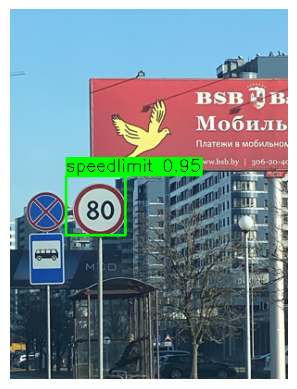

Time process:  0.9682648181915283
../data/traffic_sign_detection/images/road316.png


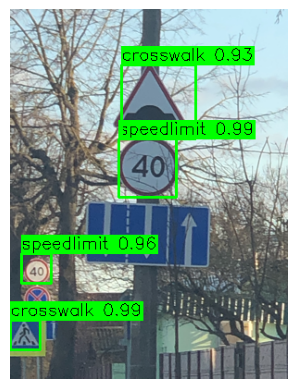

Time process:  0.9683558940887451
../data/traffic_sign_detection/images/road302.png


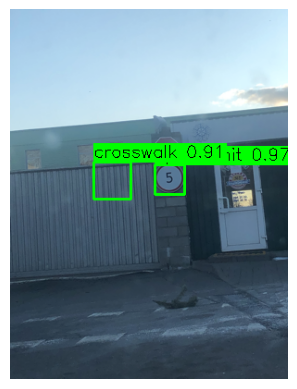

Time process:  0.9679880142211914
../data/traffic_sign_detection/images/road464.png


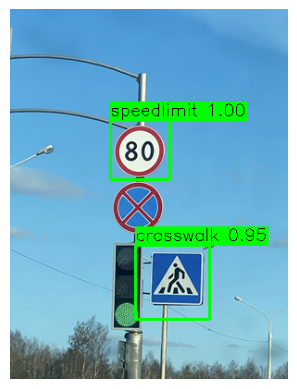

Time process:  0.9688732624053955
../data/traffic_sign_detection/images/road458.png


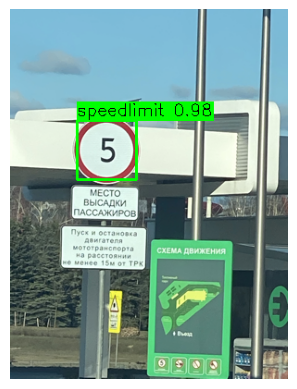

Time process:  0.9679880142211914
../data/traffic_sign_detection/images/road459.png


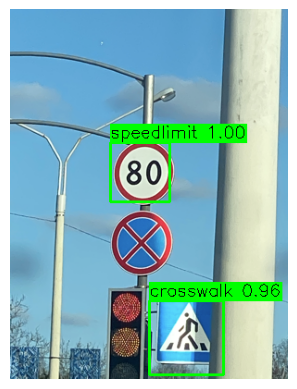

Time process:  0.9767189025878906
../data/traffic_sign_detection/images/road303.png


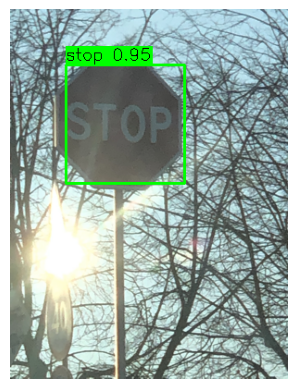

Time process:  0.9862449169158936
../data/traffic_sign_detection/images/road465.png


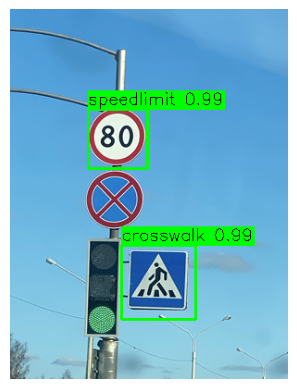

Time process:  0.9569880962371826
../data/traffic_sign_detection/images/road471.png


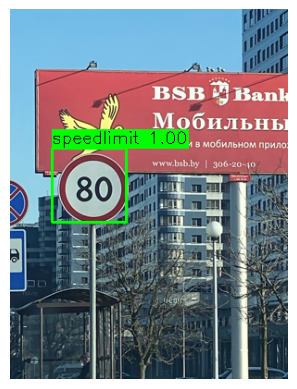

Time process:  0.9577701091766357
../data/traffic_sign_detection/images/road317.png


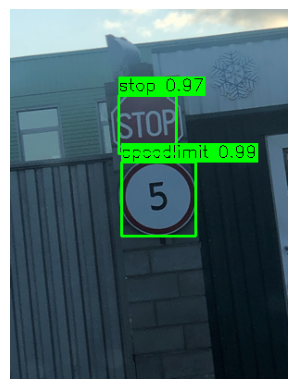

Time process:  0.9994528293609619
../data/traffic_sign_detection/images/road19.png


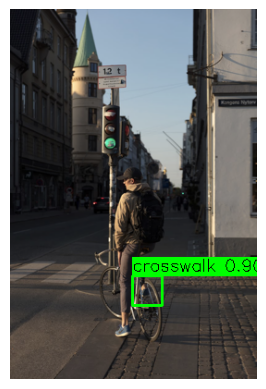

Time process:  0.854820728302002
../data/traffic_sign_detection/images/road129.png


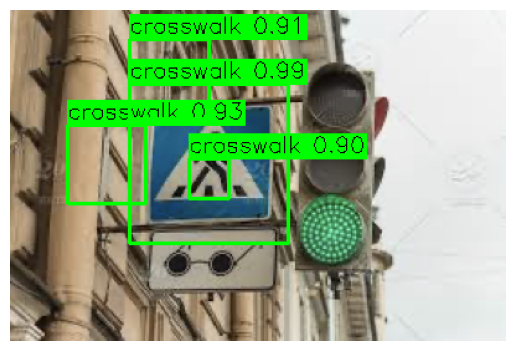

Time process:  0.8769881725311279
../data/traffic_sign_detection/images/road667.png


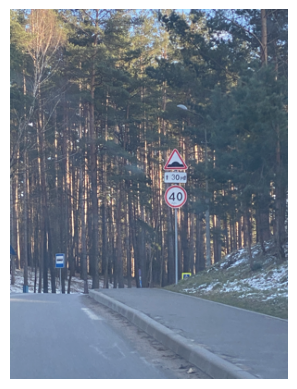

Time process:  1.061824083328247
../data/traffic_sign_detection/images/road25.png


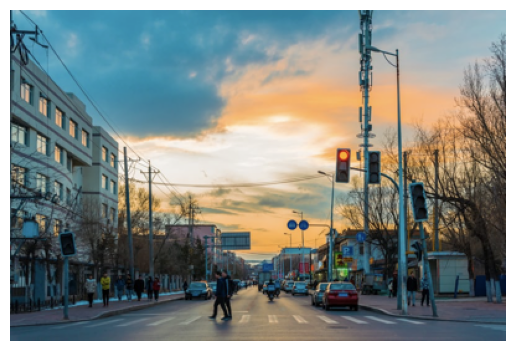

Time process:  0.8750898838043213
../data/traffic_sign_detection/images/road101.png


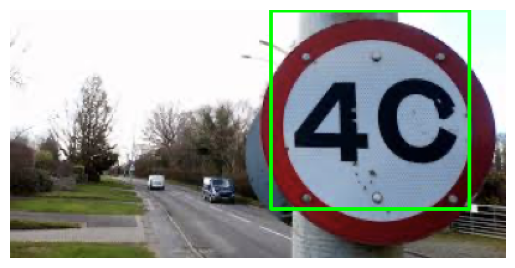

Time process:  0.5736861228942871


In [75]:
import time

for img_filename in img_filename_lst:
    start_time = time.time()
    img_filepath = os.path.join(img_dir, img_filename)
    print(img_filepath)
    bboxes = []
    img = cv2.imread(img_filepath)
    pyramid_imgs = pyramid(img)

    for pyramid_img_info in pyramid_imgs:
        pyramid_img, scale_factor = pyramid_img_info
        window_lst = sliding_window(
            pyramid_img,
            window_sizes=window_sizes,
            stride=stride,
            scale_factor=scale_factor
        )
        for window in window_lst:
            xmin, ymin, xmax, ymax = window
            object_img = pyramid_img[ymin:ymax, xmin:xmax]
            preprocessed_img = preprocess_img(object_img)
            normalized_img = scaler.transform([preprocessed_img])[0]
            decision = clf.predict_proba([normalized_img])[0]
            if np.all(decision < conf_threshold):
                continue
            else:
                predict_id = np.argmax(decision)
                conf_score = decision[predict_id]
                xmin = int(xmin / scale_factor)
                ymin = int(ymin / scale_factor)
                xmax = int(xmax / scale_factor)
                ymax = int(ymax / scale_factor)
                bboxes.append(
                    [xmin, ymin, xmax, ymax, predict_id, conf_score]
                )
    bboxes = nms(bboxes, iou_threshold)
    visualize_bbox(img, bboxes, label_encoder)

    print('Time process: ', time.time() - start_time)

#### **IV. Conclusion**

From the provided snippet, it's evident that the model successfully detected and categorized the traffic signs with significant accuracy. Nevertheless, there were instances where the traffic signs weren't detected, possibly due to their small size in the images. One potential reason for this oversight could be the high `stride` value assigned to the `sliding_window` function, causing the window to possibly skip over them. Another contributing factor could be the setting of a high `conf_threshold` (set at 0.90 in the given example). While there were a few misclassifications noted, they didn't occur at a high rate.